In [1]:
# Bibliotecas para modelo de Poisson
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import math
import os
import pickle

# Para análisis estadístico y modelos
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import poisson
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Para manejo de fechas
from datetime import datetime, timedelta

# Para ignorar advertencias
import warnings
warnings.filterwarnings('ignore')

# Configuración para visualizaciones
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Para configurar la visualización de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.2f}'.format)

print("Bibliotecas importadas correctamente para modelo de Poisson.")

Bibliotecas importadas correctamente para modelo de Poisson.


**Preparación de datos para modelo de Poisson**

In [2]:
# 1. Preparación de datos para modelo de Poisson
print("Preparando datos para modelado con Poisson...")

# Cargar los datos
print("Cargando datos...")
ruta_goleadores = "Goleadores_Procesados.csv"
df = pd.read_csv(ruta_goleadores)

# Convertir fechas a formato datetime
if 'Fecha' in df.columns:
    df['Fecha'] = pd.to_datetime(df['Fecha'], errors='coerce')

# Información básica del dataset
print(f"Dimensiones del dataset: {df.shape[0]} filas, {df.shape[1]} columnas")
print(f"Número de jugadores únicos: {df['Jugador'].nunique()}")

# Definir los jugadores top para el análisis
# Seleccionar los 5 jugadores con más goles
top_jugadores = df.groupby('Jugador')['Goles'].sum().sort_values(ascending=False).head(5).index.tolist()
print(f"Top jugadores seleccionados: {top_jugadores}")

# Crear directorio para guardar modelos si no existe
if not os.path.exists('modelos_poisson'):
    os.makedirs('modelos_poisson')

# Parámetros para división de datos
test_size = 0.2  # Último 20% de datos para prueba

# Diccionarios para almacenar resultados
modelos_poisson = {}
metricas_poisson = {}
predicciones_poisson = {}
aciertos_porcentaje_poisson = {}

# Función para calcular porcentaje de acierto (diferencia menor a 1 gol)
def calcular_porcentaje_acierto(y_true, y_pred):
    aciertos = np.sum(np.abs(y_true - np.array(y_pred)) < 1)
    return (aciertos / len(y_true)) * 100

# Función para preparar datos para el modelo de Poisson
def preparar_datos_poisson(df_original, jugador_id):
    """Preparar datos para un jugador específico para modelado con Poisson"""
    # Filtrar datos para el jugador
    df_jugador = df_original[df_original['Jugador'] == jugador_id].copy()
    
    # Mismo filtro para Hugo Rodallega que tenías en tu código anterior
    if jugador_id == 'Hugo_Rodallega':
        fecha_inicio = pd.Timestamp('2023-01-01')
        df_jugador = df_jugador[df_jugador['Fecha'] >= fecha_inicio]
        print(f"Filtrando datos de {jugador_id} desde {fecha_inicio.strftime('%d/%m/%Y')}")
    
    # Ordenar por fecha
    df_jugador = df_jugador.sort_values(by='Fecha')
    
    # Renombrar columnas con espacios
    rename_dict = {}
    for col in df_jugador.columns:
        if ' ' in col:
            new_name = col.replace(' ', '_')
            rename_dict[col] = new_name
    
    if rename_dict:
        df_jugador = df_jugador.rename(columns=rename_dict)
    
    # Crear características específicas para modelo de Poisson
    
    # 1. Promedio móvil de goles (últimos N partidos)
    df_jugador['Goles_Prom_3'] = df_jugador['Goles'].rolling(window=3, min_periods=1).mean()
    df_jugador['Goles_Prom_5'] = df_jugador['Goles'].rolling(window=5, min_periods=1).mean()
    
    # 2. Factor histórico contra oponente específico (historial actualizado)
    oponentes_unicos = df_jugador['Oponente_Estandarizado'].unique()
    df_jugador['Factor_Oponente'] = 1.0  # Valor predeterminado
    
    for oponente in oponentes_unicos:
        df_oponente = df_jugador[df_jugador['Oponente_Estandarizado'] == oponente].copy()
        
        for idx, row in df_oponente.iterrows():
            fecha_actual = row['Fecha']
            # Calcular promedio de goles contra este oponente antes de esta fecha
            hist_vs_oponente = df_oponente[(df_oponente['Fecha'] < fecha_actual)]
            
            if len(hist_vs_oponente) > 0:
                promedio_vs_oponente = hist_vs_oponente['Goles'].mean()
                # Normalizar para crear un factor multiplicativo
                factor = (promedio_vs_oponente + 1) / (df_jugador['Goles'].mean() + 1)
                df_jugador.loc[idx, 'Factor_Oponente'] = factor
    
    # 3. Verificar tendencia reciente (forma del jugador)
    df_jugador['Tendencia'] = 0
    window_size = min(5, len(df_jugador))
    for i in range(window_size, len(df_jugador)):
        recent_form = df_jugador['Goles'].iloc[i-window_size:i].values
        # Usar try/except para manejar casos donde la regresión lineal puede fallar
        try:
            slope, _, _, _, _ = stats.linregress(range(window_size), recent_form)
            df_jugador.loc[df_jugador.index[i], 'Tendencia'] = slope
        except:
            df_jugador.loc[df_jugador.index[i], 'Tendencia'] = 0
    
    # 4. Factores de contexto
    # Convertir variables categóricas en numéricas para el modelo
    if 'Día_de_la_semana' in df_jugador.columns:
        day_mapping = {
            'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3,
            'Friday': 4, 'Saturday': 5, 'Sunday': 6,
            'Lunes': 0, 'Martes': 1, 'Miércoles': 2, 'Jueves': 3,
            'Viernes': 4, 'Sábado': 5, 'Domingo': 6
        }
        df_jugador['Dia_Num'] = df_jugador['Día_de_la_semana'].map(day_mapping)
        
        # Días de fin de semana como factor (potencialmente más asistencia/importancia)
        df_jugador['Es_FinDeSemana'] = df_jugador['Dia_Num'].apply(lambda x: 1 if x >= 4 else 0)
    
    # 5. Normalizar variables para regresión
    numeric_features = ['Tiros_totales', 'Tiros_a_puerta', 'Minutos', 
                       'Goles_Prom_3', 'Goles_Prom_5', 'Factor_Oponente',
                       'Indice_Ofensivo']
    
    # Seleccionar solo las características disponibles
    available_features = [col for col in numeric_features if col in df_jugador.columns]
    
    # Crear versión normalizada de cada característica
    for feature in available_features:
        mean_val = df_jugador[feature].mean()
        std_val = df_jugador[feature].std()
        if std_val > 0:  # Evitar división por cero
            col_name = f"{feature}_norm"
            df_jugador[col_name] = (df_jugador[feature] - mean_val) / std_val
    
    # 6. Preparar dummies para equipos y oponentes
    # Seleccionar columnas que comienzan con 'Oponente_' pero excluir 'Oponente_Estandarizado' y 'Oponente_Es_Colombiano'
    oponente_cols = [col for col in df_jugador.columns if col.startswith('Oponente_') 
                    and col not in ['Oponente_Estandarizado', 'Oponente_Es_Colombiano']]
    
    # División de datos en entrenamiento y prueba
    train_size = int(len(df_jugador) * (1 - test_size))
    df_train = df_jugador.iloc[:train_size]
    df_test = df_jugador.iloc[train_size:]
    
    print(f"Datos preparados para {jugador_id}: {len(df_jugador)} registros")
    print(f"Conjunto de entrenamiento: {len(df_train)} partidos")
    print(f"Conjunto de prueba: {len(df_test)} partidos")
    
    # Guardar información de normalización para usarla en predicciones
    normalization_info = {}
    for feature in available_features:
        if feature in df_jugador.columns:
            normalization_info[feature] = {
                'mean': df_jugador[feature].mean(),
                'std': df_jugador[feature].std() if df_jugador[feature].std() > 0 else 1.0
            }
    
    return df_jugador, df_train, df_test, available_features, oponente_cols, normalization_info

# Preparar datos para cada jugador
datos_poisson = {}

for jugador in top_jugadores:
    print(f"\n--- Preparando datos para {jugador} ---")
    
    df_jugador, df_train, df_test, features, oponente_cols, norm_info = preparar_datos_poisson(df, jugador)
    
    datos_poisson[jugador] = {
        'df_completo': df_jugador,
        'train': df_train,
        'test': df_test,
        'features': features,
        'oponente_cols': oponente_cols,
        'normalization_info': norm_info
    }

Preparando datos para modelado con Poisson...
Cargando datos...
Dimensiones del dataset: 662 filas, 73 columnas
Número de jugadores únicos: 5
Top jugadores seleccionados: ['Dayro_Moreno', 'Leonardo_Castro', 'Carlos_Bacca', 'Marco_Perez', 'Hugo_Rodallega']

--- Preparando datos para Dayro_Moreno ---
Datos preparados para Dayro_Moreno: 146 registros
Conjunto de entrenamiento: 116 partidos
Conjunto de prueba: 30 partidos

--- Preparando datos para Leonardo_Castro ---
Datos preparados para Leonardo_Castro: 138 registros
Conjunto de entrenamiento: 110 partidos
Conjunto de prueba: 28 partidos

--- Preparando datos para Carlos_Bacca ---
Datos preparados para Carlos_Bacca: 135 registros
Conjunto de entrenamiento: 108 partidos
Conjunto de prueba: 27 partidos

--- Preparando datos para Marco_Perez ---
Datos preparados para Marco_Perez: 121 registros
Conjunto de entrenamiento: 96 partidos
Conjunto de prueba: 25 partidos

--- Preparando datos para Hugo_Rodallega ---
Filtrando datos de Hugo_Rodalle

**Entrenamiento**


Iniciando entrenamiento de modelos de Poisson para cada jugador...

=== Entrenamiento para Dayro_Moreno ===
Formula del modelo: Goles ~ Tiros_totales_norm + Tiros_a_puerta_norm + Minutos_norm + Goles_Prom_3_norm + Goles_Prom_5_norm + Factor_Oponente_norm + Indice_Ofensivo_norm + Sede_Local + Sede_Visitante
Entrenando modelo de regresión de Poisson...

Resumen de coeficientes principales:
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.7999      0.133     -6.037      0.000      -1.060      -0.540
Tiros_totales_norm      -0.2947      0.208     -1.414      0.157      -0.703       0.114
Tiros_a_puerta_norm      0.6593      0.188      3.503      0.000       0.290       1.028
Minutos_norm             0.2036      0.269      0.757      0.449      -0.324       0.731
Goles_Prom_3_norm        0.2412      0.252      0.956      0.339      -0.2

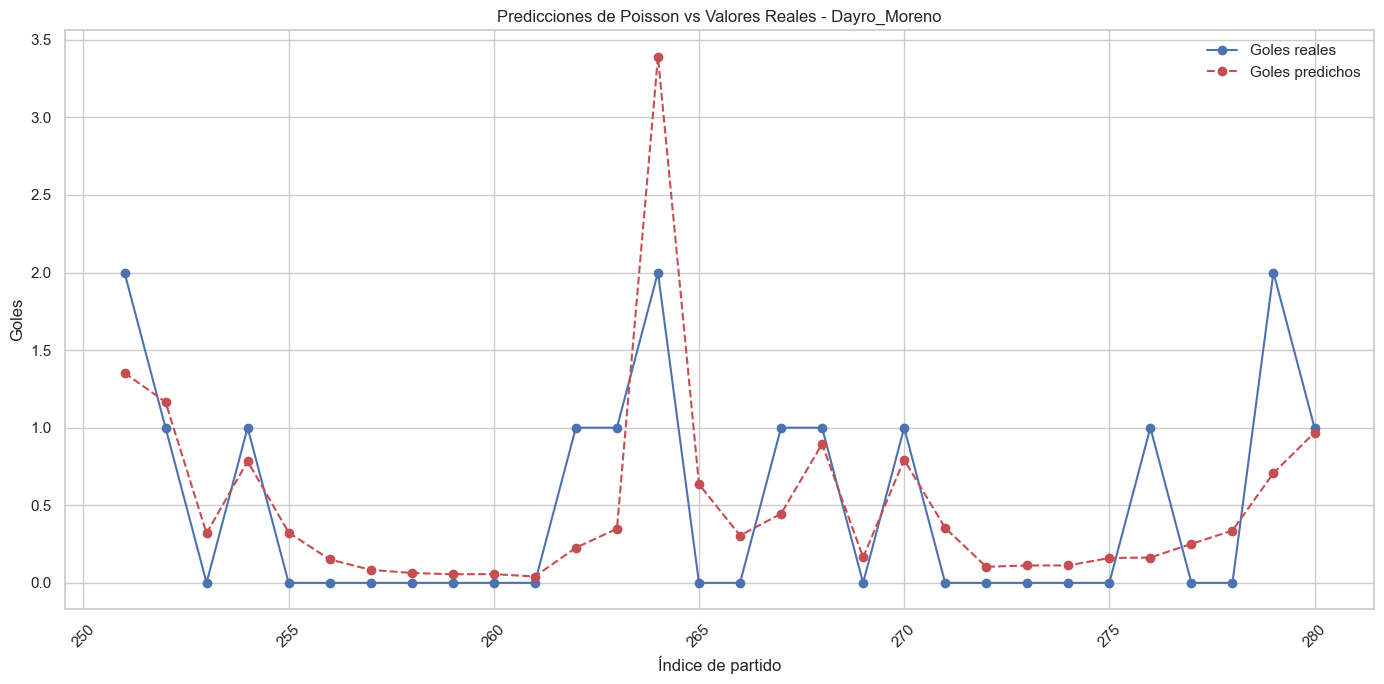

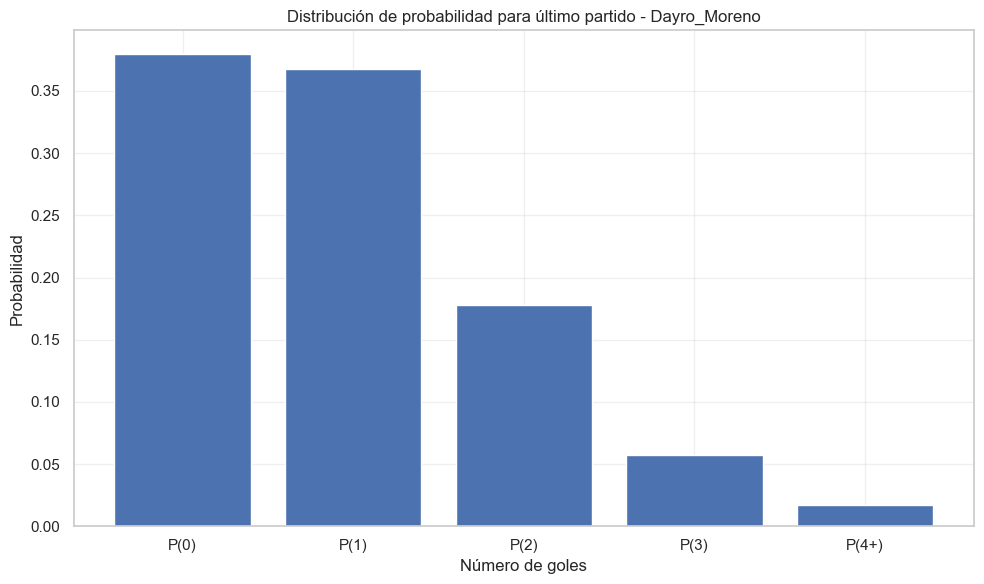


=== Entrenamiento para Leonardo_Castro ===
Formula del modelo: Goles ~ Tiros_totales_norm + Tiros_a_puerta_norm + Minutos_norm + Goles_Prom_3_norm + Goles_Prom_5_norm + Factor_Oponente_norm + Indice_Ofensivo_norm + Sede_Local + Sede_Visitante
Entrenando modelo de regresión de Poisson...

Resumen de coeficientes principales:
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.8456      0.134     -6.306      0.000      -1.108      -0.583
Tiros_totales_norm       0.0115      0.184      0.063      0.950      -0.349       0.372
Tiros_a_puerta_norm      0.6250      0.162      3.852      0.000       0.307       0.943
Minutos_norm            -0.0934      0.219     -0.426      0.670      -0.523       0.336
Goles_Prom_3_norm        0.3879      0.243      1.598      0.110      -0.088       0.863
Goles_Prom_5_norm        0.0833      0.217      0.

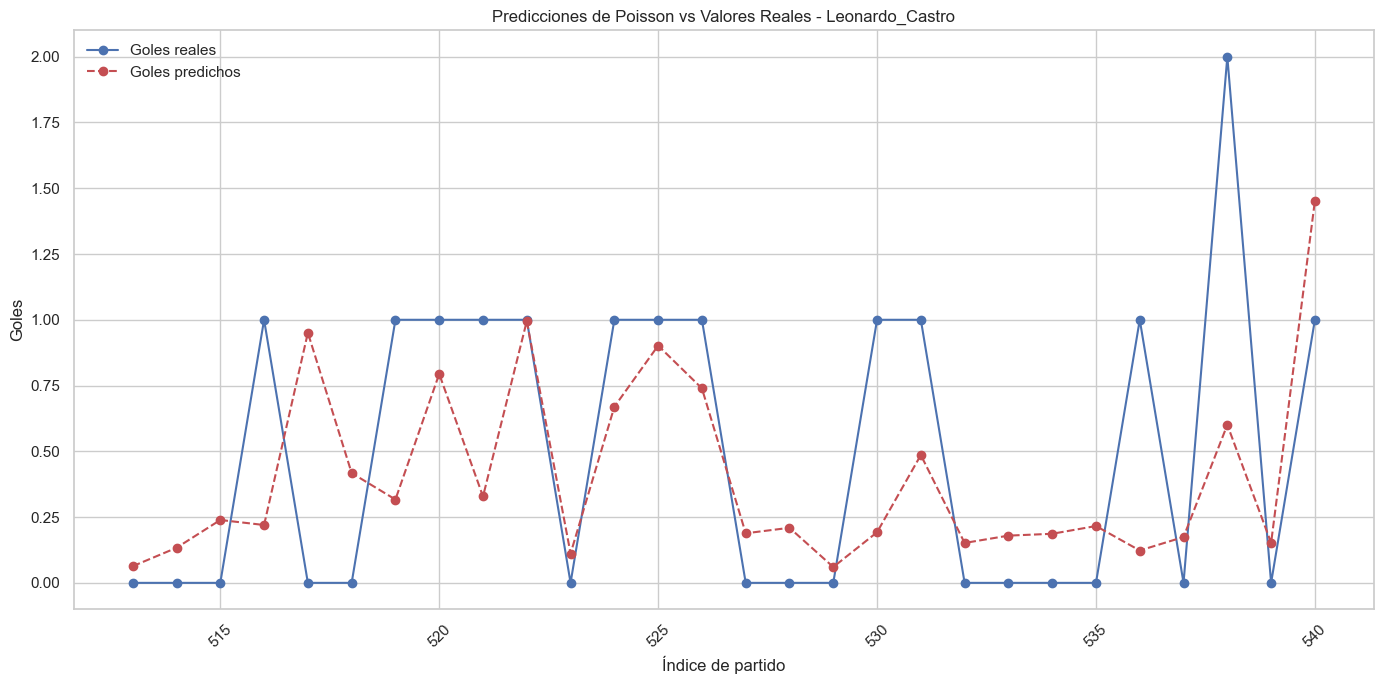

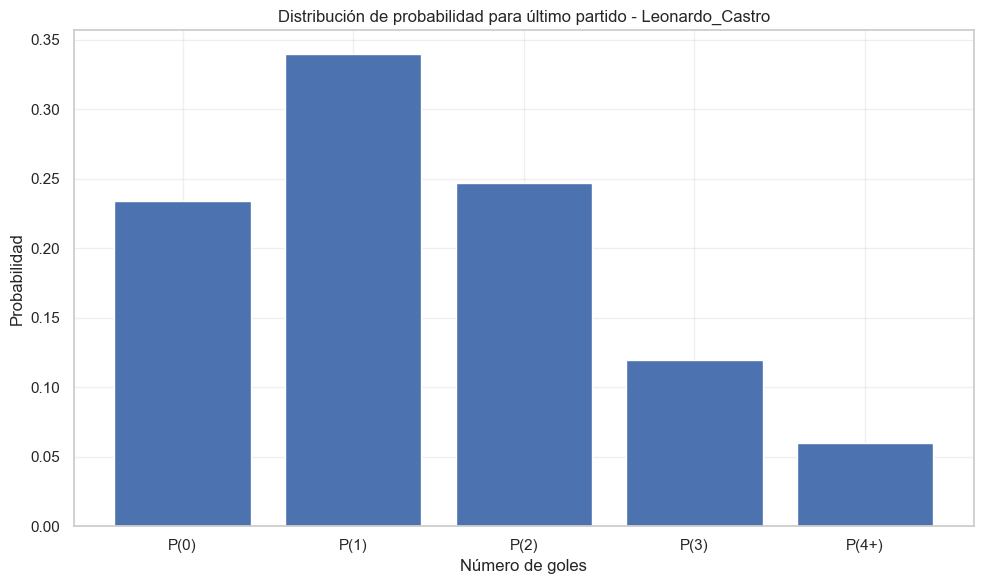


=== Entrenamiento para Carlos_Bacca ===
Formula del modelo: Goles ~ Tiros_totales_norm + Tiros_a_puerta_norm + Minutos_norm + Goles_Prom_3_norm + Goles_Prom_5_norm + Factor_Oponente_norm + Indice_Ofensivo_norm + Sede_Local + Sede_Visitante
Entrenando modelo de regresión de Poisson...

Resumen de coeficientes principales:
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.0529      0.173     -6.091      0.000      -1.392      -0.714
Tiros_totales_norm      -0.0465      0.229     -0.203      0.839      -0.495       0.403
Tiros_a_puerta_norm      0.7041      0.213      3.308      0.001       0.287       1.121
Minutos_norm             0.3350      0.310      1.079      0.280      -0.273       0.943
Goles_Prom_3_norm        0.2108      0.263      0.803      0.422      -0.304       0.726
Goles_Prom_5_norm        0.2365      0.270      0.876

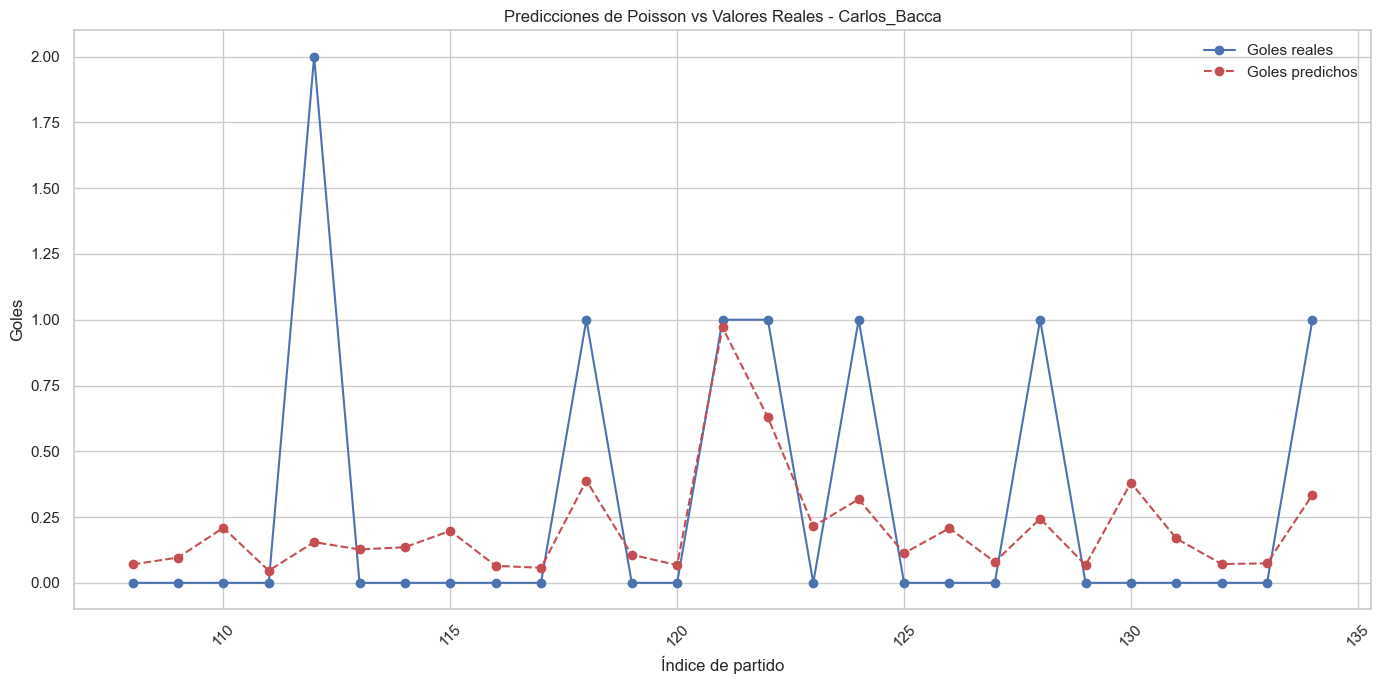

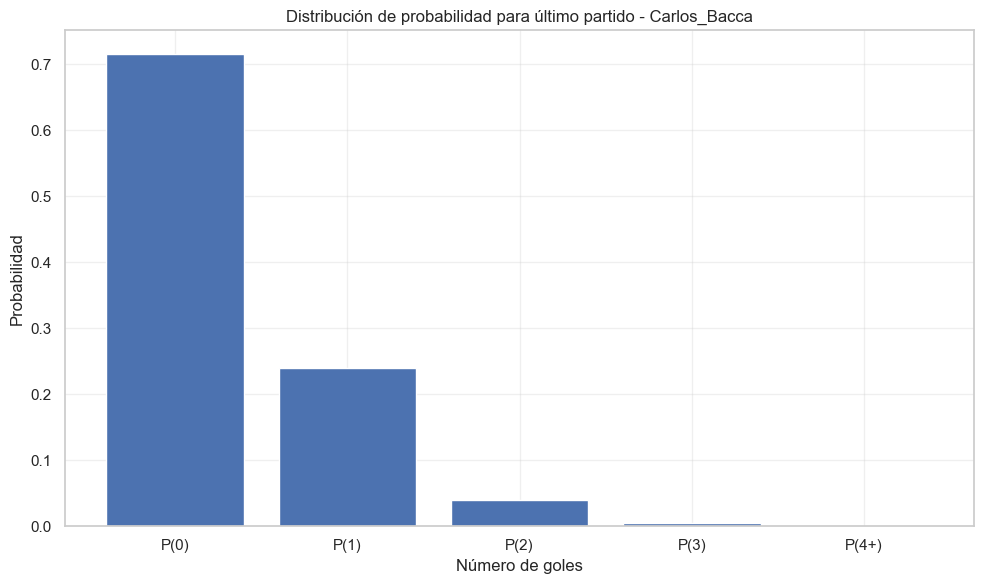


=== Entrenamiento para Marco_Perez ===
Formula del modelo: Goles ~ Tiros_totales_norm + Tiros_a_puerta_norm + Minutos_norm + Goles_Prom_3_norm + Goles_Prom_5_norm + Factor_Oponente_norm + Indice_Ofensivo_norm + Sede_Local + Sede_Visitante
Entrenando modelo de regresión de Poisson...

Resumen de coeficientes principales:
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.1162      0.216     -5.177      0.000      -1.539      -0.694
Tiros_totales_norm       0.0197      0.235      0.084      0.933      -0.441       0.481
Tiros_a_puerta_norm      0.5083      0.215      2.368      0.018       0.088       0.929
Minutos_norm             0.3666      0.404      0.909      0.364      -0.424       1.158
Goles_Prom_3_norm        0.3387      0.238      1.424      0.154      -0.127       0.805
Goles_Prom_5_norm        0.2613      0.236      1.106 

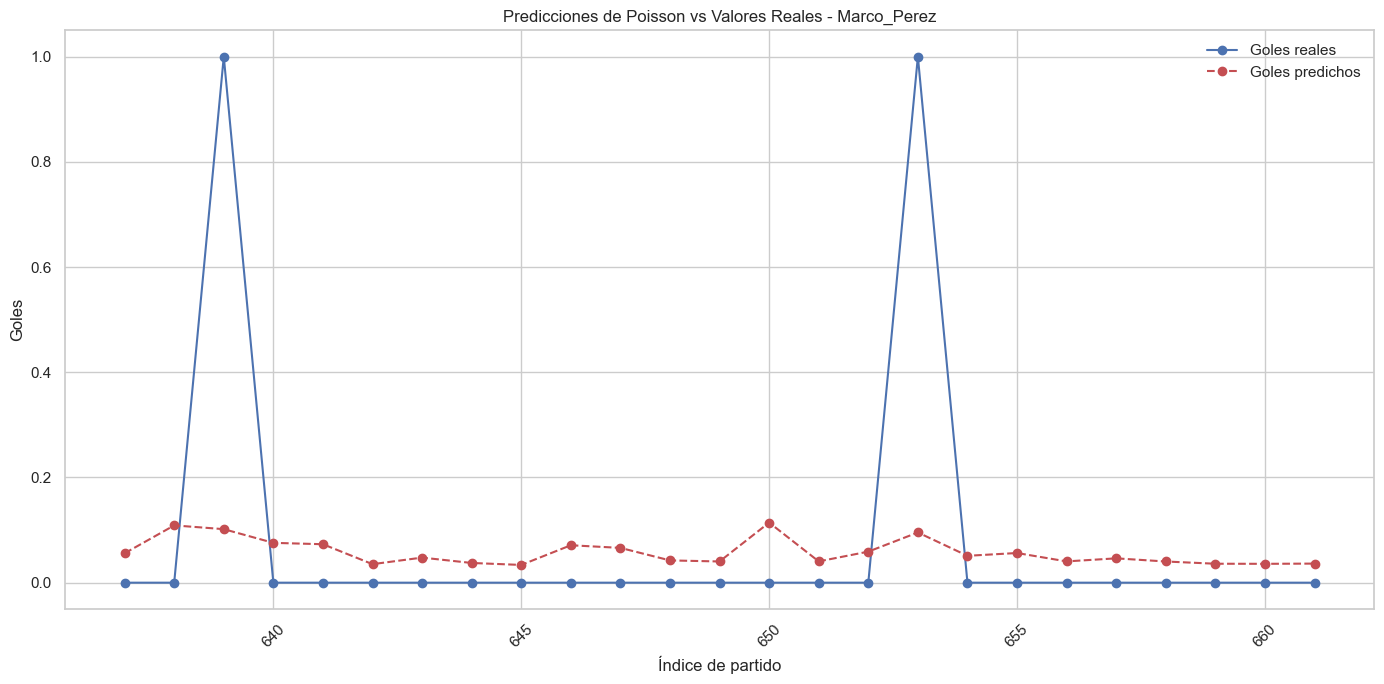

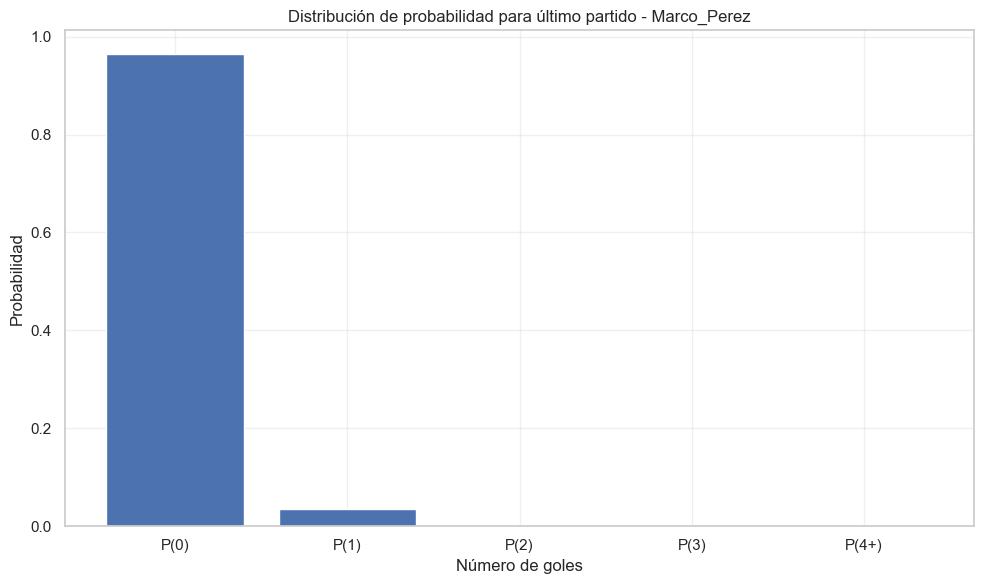


=== Entrenamiento para Hugo_Rodallega ===
Formula del modelo: Goles ~ Tiros_totales_norm + Tiros_a_puerta_norm + Minutos_norm + Goles_Prom_3_norm + Goles_Prom_5_norm + Factor_Oponente_norm + Indice_Ofensivo_norm + Sede_Local + Sede_Visitante
Entrenando modelo de regresión de Poisson...

Resumen de coeficientes principales:
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.9141      0.171     -5.333      0.000      -1.250      -0.578
Tiros_totales_norm       0.0714      0.216      0.331      0.741      -0.352       0.495
Tiros_a_puerta_norm      0.3339      0.267      1.251      0.211      -0.189       0.857
Minutos_norm             0.1689      0.286      0.590      0.555      -0.392       0.730
Goles_Prom_3_norm        0.2883      0.289      0.998      0.318      -0.278       0.855
Goles_Prom_5_norm        0.7126      0.314      2.2

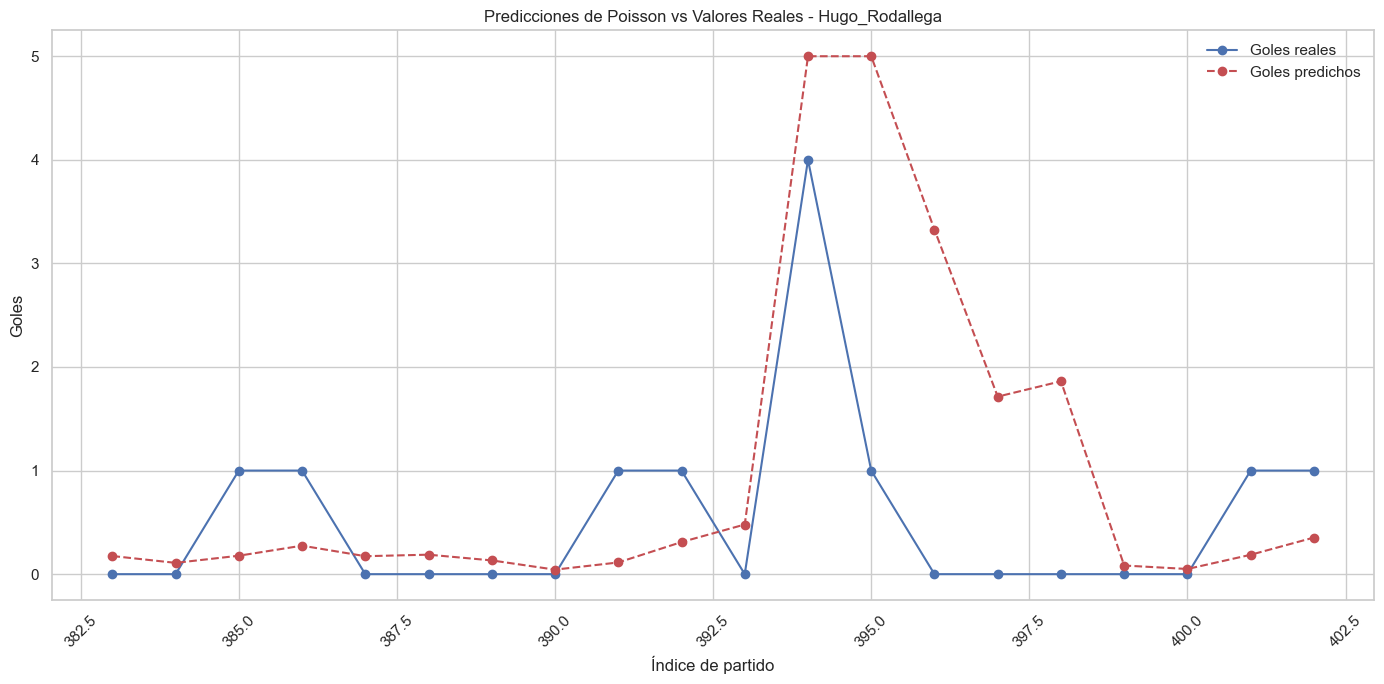

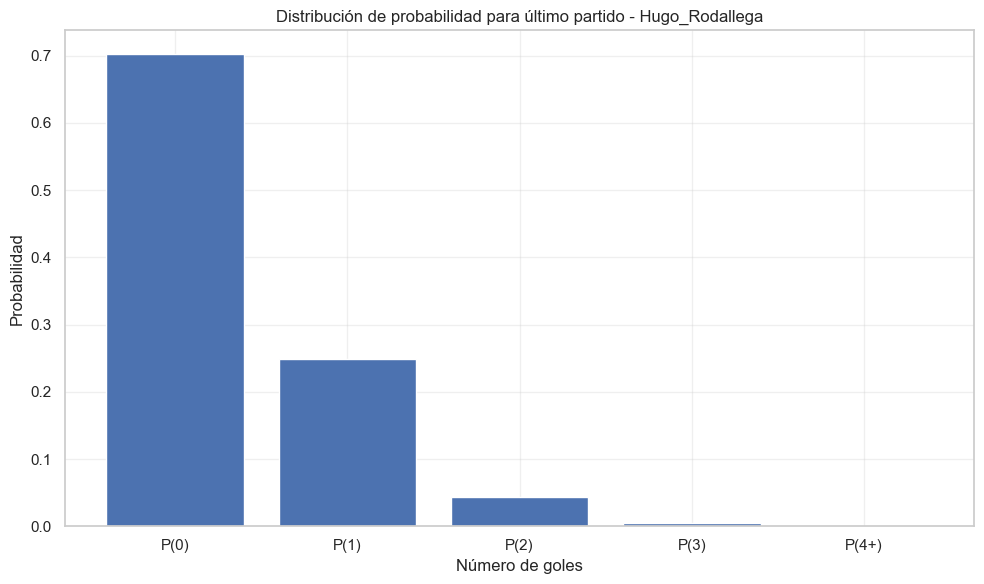


=== Comparación de rendimiento entre jugadores (Poisson) ===
                  Modelo  RMSE  MAE  Acierto (%)
Marco_Perez      Poisson  0.26 0.12       100.00
Leonardo_Castro  Poisson  0.50 0.38        96.43
Carlos_Bacca     Poisson  0.47 0.28        96.30
Dayro_Moreno     Poisson  0.49 0.35        93.33
Hugo_Rodallega   Poisson  1.39 0.90        75.00


<Figure size 1200x600 with 0 Axes>

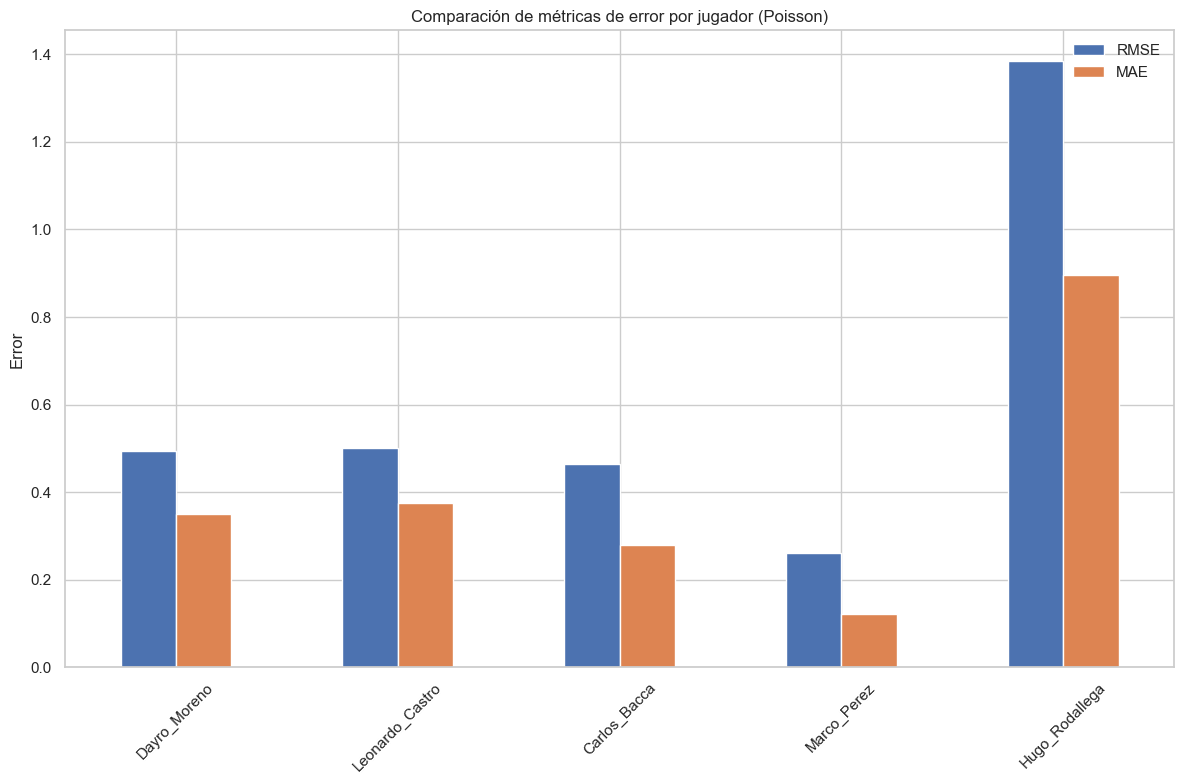

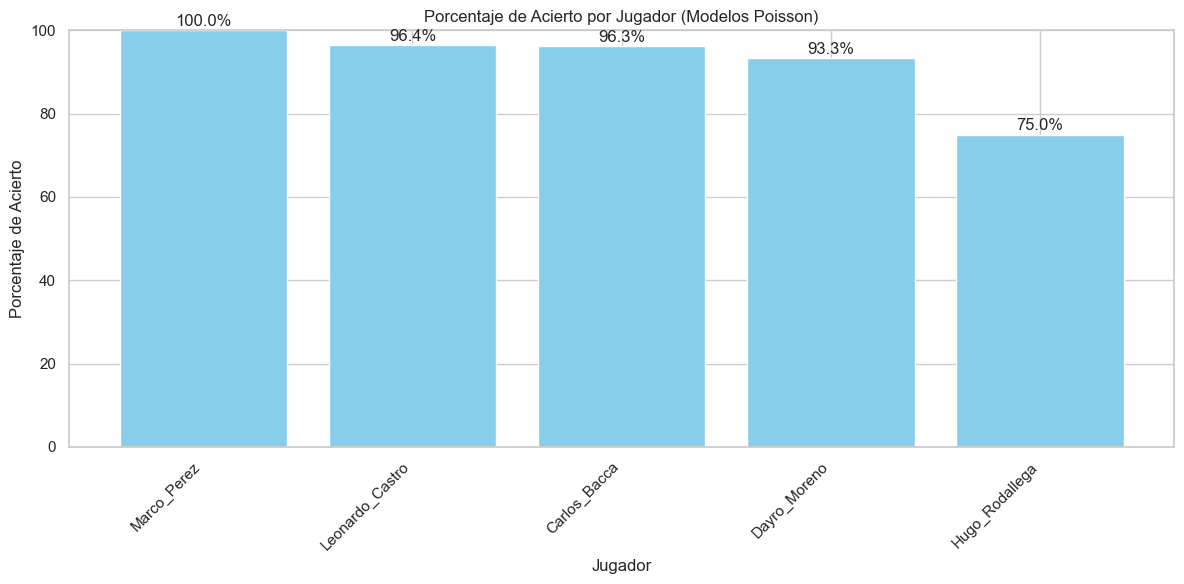

In [3]:
# 2. Entrenamiento de modelos de Poisson para cada jugador
print("\nIniciando entrenamiento de modelos de Poisson para cada jugador...")

for jugador in top_jugadores:
    print(f"\n=== Entrenamiento para {jugador} ===")
    
    # Obtener datos preparados
    datos_jug = datos_poisson[jugador]
    df_train = datos_jug['train']
    df_test = datos_jug['test']
    features = datos_jug['features']
    oponente_cols = datos_jug['oponente_cols']
    normalization_info = datos_jug['normalization_info']
    
    if len(df_train) < 10:
        print(f"Insuficientes datos para {jugador}. Se necesitan al menos 10 observaciones.")
        continue
    
    try:
        # Corregir nombres de columnas: reemplazar espacios con guiones bajos
        rename_dict = {}
        for col in df_train.columns:
            if ' ' in col:
                new_name = col.replace(' ', '_')
                rename_dict[col] = new_name
        
        if rename_dict:
            print(f"Renombrando {len(rename_dict)} columnas para eliminar espacios")
            df_train = df_train.rename(columns=rename_dict)
            df_test = df_test.rename(columns=rename_dict)
            
            # Actualizar nombres de features
            features = [rename_dict.get(f, f) for f in features]
        
        # Seleccionar las características para el modelo
        # Comenzamos con un conjunto básico
        features_norm = [f for f in df_train.columns if f.endswith('_norm') and not pd.isna(df_train[f]).any()]
        
        # Añadir variables contextuales
        context_vars = ['Sede_Local', 'Sede_Visitante']
        context_vars = [var for var in context_vars if var in df_train.columns]
        
        # Crear la fórmula para statsmodels
        formula_terms = []
        
        # Términos básicos
        for feat in features_norm:
            formula_terms.append(feat)
        
        # Variables contextuales
        for var in context_vars:
            formula_terms.append(var)
        
        # Oponentes (solo incluir algunos para evitar sobreajuste)
        top_oponentes = []
        if oponente_cols:
            # Seleccionar oponentes con suficientes datos
            for col in oponente_cols:
                # Verificar si el nombre del oponente tiene espacios y corregirlo
                col_fixed = rename_dict.get(col, col)
                try:
                    # Verificar si la columna es numérica
                    if pd.api.types.is_numeric_dtype(df_train[col_fixed]):
                        # Si es numérica, verificar la suma
                        if df_train[col_fixed].sum() >= 2:  # Al menos 2 partidos contra este oponente
                            top_oponentes.append(col_fixed)
                    else:
                        # Si no es numérica, intentar convertir
                        valores = pd.to_numeric(df_train[col_fixed], errors='coerce')
                        if valores.fillna(0).sum() >= 2:
                            # Convertir la columna a numérica en el dataframe
                            df_train[col_fixed] = valores
                            df_test[col_fixed] = pd.to_numeric(df_test[col_fixed], errors='coerce').fillna(0)
                            top_oponentes.append(col_fixed)
                except Exception as e:
                    print(f"  Ignorando columna {col_fixed}: {str(e)}")
            
            # Limitar a máximo 5 oponentes para evitar sobreajuste
            top_oponentes = top_oponentes[:5]
            formula_terms.extend(top_oponentes)
        
        # Crear la fórmula final
        if not formula_terms:
            print(f"No hay suficientes variables para crear modelo para {jugador}")
            continue
            
        formula = "Goles ~ " + " + ".join(formula_terms)
        print(f"Formula del modelo: {formula}")
        
        # Verificar que todas las variables sean numéricas
        for term in formula_terms:
            if term in df_train.columns and not pd.api.types.is_numeric_dtype(df_train[term]):
                print(f"  Convirtiendo columna {term} a numérica")
                df_train[term] = pd.to_numeric(df_train[term], errors='coerce').fillna(0)
                if term in df_test.columns:
                    df_test[term] = pd.to_numeric(df_test[term], errors='coerce').fillna(0)
        
        # Verificar que los nombres en la fórmula sean válidos
        for term in formula_terms:
            if ' ' in term:
                raise ValueError(f"El término '{term}' contiene espacios, lo que causará errores en statsmodels")
        
        # Entrenar modelo de regresión de Poisson
        print("Entrenando modelo de regresión de Poisson...")
        modelo = smf.glm(formula=formula, data=df_train, family=sm.families.Poisson()).fit()
        
        # Resumen del modelo
        print("\nResumen de coeficientes principales:")
        print(modelo.summary().tables[1])
        
        # Verificar si hay coeficientes extremadamente grandes
        large_coefs = [name for name, value in modelo.params.items() 
                       if abs(value) > 10 and name != 'Intercept']
        if large_coefs:
            print(f"ADVERTENCIA: Coeficientes extremadamente grandes detectados: {large_coefs}")
            print("Esto puede causar predicciones inestables o erróneas")
        
        # Predecir en conjunto de prueba
        print("\nGenerando predicciones en conjunto de prueba...")
        # Verificar que todas las columnas necesarias existan en el conjunto de prueba
        missing_cols = [col for col in formula_terms if col not in df_test.columns]
        if missing_cols:
            print(f"  Faltan columnas en conjunto de prueba: {missing_cols}")
            # Agregar columnas faltantes con valores 0
            for col in missing_cols:
                df_test[col] = 0
        
        # Crear dataframe con las mismas columnas que el conjunto de entrenamiento
        X_test = df_test[formula_terms].copy()
        
        # Predecir tasas lambda (media de Poisson)
        lambda_pred = modelo.predict(X_test)
        
        # IMPORTANTE: Limitar los valores de lambda para evitar predicciones extremas
        lambda_pred_clipped = np.clip(lambda_pred, 0, 5)
        
        # Convertir tasas lambda a goles esperados (valor esperado de Poisson)
        y_pred = lambda_pred_clipped
        y_true = df_test['Goles'].values
        
        # Calcular distribuciones de probabilidad para cada partido
        prob_distributions = []
        for lambda_val in lambda_pred_clipped:
            # Calcular probabilidades para 0, 1, 2, 3, 4+ goles
            probs = [poisson.pmf(i, lambda_val) for i in range(5)]
            # Ajustar la probabilidad para 4+ goles
            probs[4] = 1 - sum(probs[:4])
            prob_distributions.append(probs)
        
        # Convertir a DataFrame para mejor visualización
        prob_df = pd.DataFrame(prob_distributions, 
                              columns=['P(0)', 'P(1)', 'P(2)', 'P(3)', 'P(4+)'],
                              index=df_test.index)
        
        # Métricas de evaluación
        mse = mean_squared_error(y_true, y_pred)
        rmse = math.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        porcentaje_acierto = calcular_porcentaje_acierto(y_true, y_pred)
        
        print(f"MSE: {mse:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"Porcentaje de acierto: {porcentaje_acierto:.2f}%")
        
        # Guardar resultados y modelo
        modelos_poisson[jugador] = modelo
        metricas_poisson[jugador] = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'Porcentaje_Acierto': porcentaje_acierto
        }
        predicciones_poisson[jugador] = {
            'test_pred': y_pred,
            'test_real': y_true,
            'prob_dist': prob_df
        }
        
        # Guardar modelo en archivo pickle
        ruta_modelo = f"modelos_poisson/poisson_{jugador.replace(' ', '_')}.pkl"
        with open(ruta_modelo, 'wb') as file:
            modelo_guardado = {
                'modelo_entrenado': modelo,
                'modelo_config': {
                    'formula': formula,
                    'features': formula_terms,
                    'tipo_modelo': 'Poisson',
                    'num_coeficientes': len(modelo.params)
                },
                'datos_entrenamiento': {
                    'periodo_inicio': str(df_train['Fecha'].min()),
                    'periodo_fin': str(df_train['Fecha'].max()),
                    'num_observaciones': len(df_train)
                },
                'metricas': {
                    'RMSE': rmse,
                    'MAE': mae,
                    'Acierto': porcentaje_acierto,
                    'MSE': mse
                },
                'normalization_info': normalization_info
            }
            pickle.dump(modelo_guardado, file)
        
        print(f"Modelo guardado correctamente en: {ruta_modelo}")
        
        # Visualización de resultados - Predicciones vs Valores reales
        plt.figure(figsize=(14, 7))
        plt.plot(df_test.index, y_true, 'bo-', label='Goles reales')
        plt.plot(df_test.index, y_pred, 'ro--', label='Goles predichos')
        plt.title(f'Predicciones de Poisson vs Valores Reales - {jugador}')
        plt.xlabel('Índice de partido')
        plt.ylabel('Goles')
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
        # Visualización de distribución de probabilidad para un partido ejemplo
        if len(prob_df) > 0:
            plt.figure(figsize=(10, 6))
            # Tomar el último partido como ejemplo
            ultimo_partido = prob_df.iloc[-1]
            plt.bar(ultimo_partido.index, ultimo_partido.values)
            plt.title(f'Distribución de probabilidad para último partido - {jugador}')
            plt.xlabel('Número de goles')
            plt.ylabel('Probabilidad')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
        # Guardar porcentaje de acierto para comparación final
        aciertos_porcentaje_poisson[jugador] = {
            'Modelo': 'Poisson',
            'RMSE': rmse,
            'MAE': mae,
            'Acierto (%)': porcentaje_acierto
        }
        
    except Exception as e:
        print(f"Error al entrenar modelo para {jugador}: {str(e)}")
        # Mostrar información detallada para depuración
        import traceback
        traceback.print_exc()

# Comparación de rendimiento entre jugadores
if metricas_poisson:
    print("\n=== Comparación de rendimiento entre jugadores (Poisson) ===")
    
    # Crear DataFrame para comparación
    df_comparacion = pd.DataFrame.from_dict(aciertos_porcentaje_poisson, orient='index')
    df_comparacion = df_comparacion.sort_values('Acierto (%)', ascending=False)
    
    print(df_comparacion)
    
    # Visualización de métricas de error
    plt.figure(figsize=(12, 6))
    error_data = pd.DataFrame({
        'RMSE': [metricas_poisson[jugador]['RMSE'] for jugador in metricas_poisson],
        'MAE': [metricas_poisson[jugador]['MAE'] for jugador in metricas_poisson]
    }, index=metricas_poisson.keys())
    error_data.plot(kind='bar')
    plt.title('Comparación de métricas de error por jugador (Poisson)')
    plt.ylabel('Error')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Visualización del porcentaje de acierto
    plt.figure(figsize=(12, 6))
    plt.bar(df_comparacion.index, df_comparacion['Acierto (%)'], color='skyblue')
    plt.title('Porcentaje de Acierto por Jugador (Modelos Poisson)')
    plt.xlabel('Jugador')
    plt.ylabel('Porcentaje de Acierto')
    plt.ylim(0, 100)
    for i, v in enumerate(df_comparacion['Acierto (%)']):
        plt.text(i, v + 1, f"{v:.1f}%", ha='center')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

**Prediccion 2025**

 Iniciando sistema de predicción de goles con modelo Poisson...
 Cargando datos históricos y calendario...
 Renombradas 29 columnas para eliminar espacios

Realizando predicciones para cada jugador...

 Procesando: Carlos Bacca
    Modelo cargado: poisson_Carlos_Bacca.pkl
    Tipo: Poisson | Num. coeficientes: 10 | RMSE: 0.47
    Prediciendo 20 partidos...


   Prediciendo:   0%|                                    | 0/20 [00:00<?, ?it/s]

    Resumen: 20 partidos | Promedio: 0.23 | Máximo: 0.32

 Procesando: Marco Perez
    Modelo cargado: poisson_Marco_Perez.pkl
    Tipo: Poisson | Num. coeficientes: 10 | RMSE: 0.26
    Prediciendo 20 partidos...


   Prediciendo:   0%|                                    | 0/20 [00:00<?, ?it/s]

    Resumen: 20 partidos | Promedio: 0.14 | Máximo: 0.18

 Procesando: Dayro Moreno
    Modelo cargado: poisson_Dayro_Moreno.pkl
    Tipo: Poisson | Num. coeficientes: 10 | RMSE: 0.49
    Prediciendo 20 partidos...


   Prediciendo:   0%|                                    | 0/20 [00:00<?, ?it/s]

    Resumen: 20 partidos | Promedio: 0.81 | Máximo: 1.05

 Procesando: Hugo Rodallega
    Modelo cargado: poisson_Hugo_Rodallega.pkl
    Tipo: Poisson | Num. coeficientes: 10 | RMSE: 1.39
    Prediciendo 20 partidos...


   Prediciendo:   0%|                                    | 0/20 [00:00<?, ?it/s]

    Resumen: 20 partidos | Promedio: 0.32 | Máximo: 1.32

 Procesando: Leonardo Castro
    Modelo cargado: poisson_Leonardo_Castro.pkl
    Tipo: Poisson | Num. coeficientes: 10 | RMSE: 0.50
    Prediciendo 20 partidos...


   Prediciendo:   0%|                                    | 0/20 [00:00<?, ?it/s]

    Resumen: 20 partidos | Promedio: 0.53 | Máximo: 1.45

 Predicciones completadas y guardadas en predicciones_calendario_poisson2025.csv

 RESUMEN DE PREDICCIONES POR JUGADOR (POISSON):
                 mean  min  max  count
Jugador                               
Dayro Moreno     0.81 0.61 1.05     20
Leonardo Castro  0.53 0.14 1.45     20
Hugo Rodallega   0.32 0.16 1.32     20
Carlos Bacca     0.23 0.14 0.32     20
Marco Perez      0.14 0.06 0.18     20

 MEJOR RENDIMIENTO PREDICHO CONTRA CADA EQUIPO:
                                Jugador  Goles_Predichos
Oponente                                                
Alianza FC                 Dayro Moreno             0.99
América                    Dayro Moreno             0.96
Atletico Nacional       Leonardo Castro             0.49
Atlético Nacional          Dayro Moreno             0.67
Boyacá Chicó               Dayro Moreno             0.71
Bucaramanga                Dayro Moreno             1.00
CD América                 Carlos 

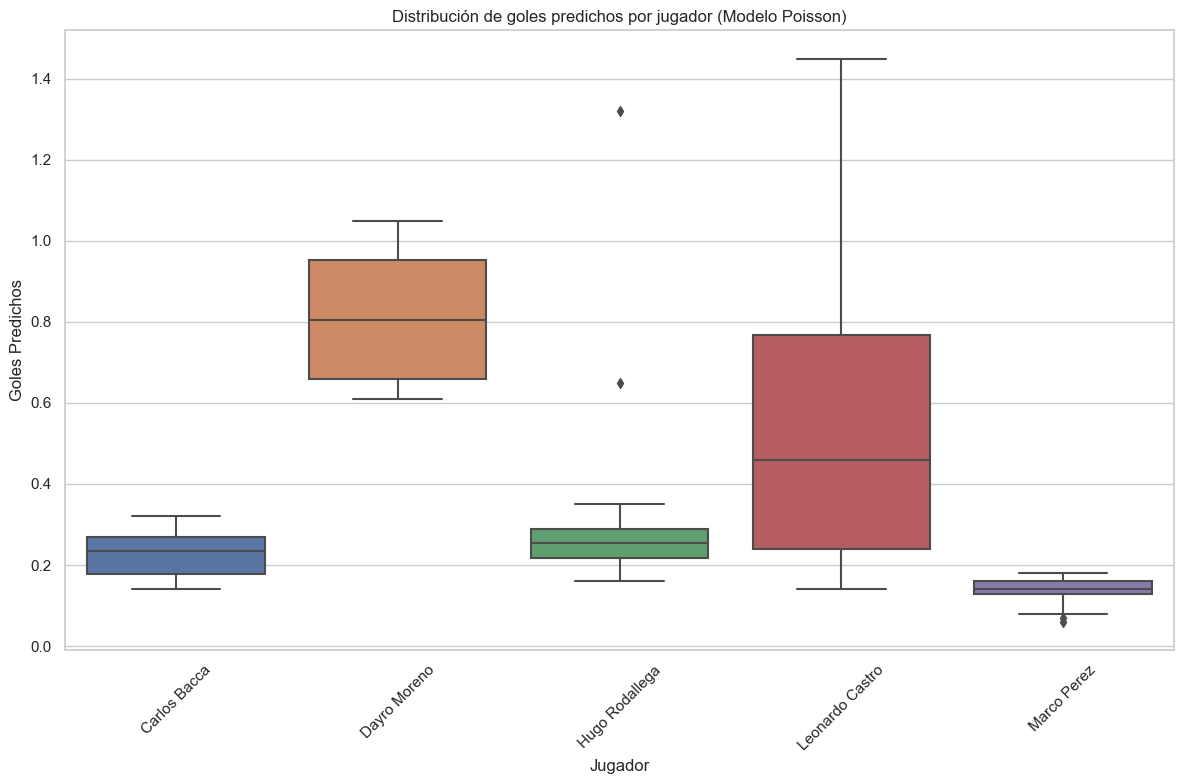


 ¡Proceso completado con éxito!


In [4]:
# 3. Sistema de predicción con Poisson para el calendario 2025
def predecir_goles_poisson_calendario_2025(ruta_calendario, carpeta_modelos, ruta_datos_historicos):
    print(" Iniciando sistema de predicción de goles con modelo Poisson...")
    print(" Cargando datos históricos y calendario...")
    
    # Cargar datos históricos
    datos_historicos = pd.read_csv(ruta_datos_historicos)
    datos_historicos['Fecha'] = pd.to_datetime(datos_historicos['Fecha'], errors='coerce')
    
    # Renombrar columnas con espacios para evitar problemas
    rename_dict = {}
    for col in datos_historicos.columns:
        if ' ' in col:
            new_name = col.replace(' ', '_')
            rename_dict[col] = new_name
    
    if rename_dict:
        datos_historicos = datos_historicos.rename(columns=rename_dict)
        print(f" Renombradas {len(rename_dict)} columnas para eliminar espacios")
    
    # Cargar el calendario
    calendario = pd.read_csv(ruta_calendario)
    calendario['Fecha'] = pd.to_datetime(calendario['Fecha'])
    
    # Función para estandarizar nombres de equipos
    def estandarizar_nombre_equipo(nombre):
        # Mapeo de nombres de equipos (versión simplificada)
        mapeo_equipos = {
            'Atlético Junior': 'Junior',
            'Junior': 'Junior',
            'Nacional': 'Atletico Nacional',
            'Deportivo Pereira': 'Pereira',
            'Atlético Bucaramanga': 'Bucaramanga',
            'Bucaramanga': 'Bucaramanga',
            'Santa Fe': 'Independiente Santa Fe',
            'Independiente Santa Fe': 'Independiente Santa Fe',
            'Cali': 'Deportivo Cali',
            'Deportivo Cali': 'Deportivo Cali',
            'America': 'CD América',
            'Millonarios': 'Millonarios',
            'Once Caldas': 'Once Caldas',
            'Águilas Doradas': 'Rionegro',
            'La Equidad': 'La Equidad',
            'Envigado': 'Envigado',
            'Fortaleza': 'Fortaleza CEIF',
            'Unión Magdalena': 'Unión Magdalena',
            'Pasto': 'Deportivo Pasto',
            'Deportivo Pasto': 'Deportivo Pasto',
            'Tolima': 'Deportes Tolima',
            'Deportes Tolima': 'Deportes Tolima',
            'Alianza': 'Alianza FC',
            'Medellín': 'Independiente Medellín',
            'Chicó': 'Boyacá Chicó',
            'Llaneros': 'Llaneros'
        }
        
        if nombre in mapeo_equipos:
            return mapeo_equipos[nombre]
        return nombre
    
    # Función para estandarizar nombres de jugadores
    def estandarizar_nombre_jugador(nombre):
        mapeo_jugadores = {
            'Carlos_Bacca': 'Carlos Bacca',
            'Dayro_Moreno': 'Dayro Moreno',
            'Hugo_Rodallega': 'Hugo Rodallega',
            'Leonardo_Castro': 'Leonardo Castro',
            'Marco_Perez': 'Marco Perez'
        }
        
        if nombre in mapeo_jugadores:
            return mapeo_jugadores[nombre]
        return nombre
    
    # Función para estandarizar nombres de jugadores en formato inverso
    def estandarizar_nombre_jugador_inverso(nombre):
        mapeo_jugadores = {
            'Carlos Bacca': 'Carlos_Bacca',
            'Dayro Moreno': 'Dayro_Moreno',
            'Hugo Rodallega': 'Hugo_Rodallega',
            'Leonardo Castro': 'Leonardo_Castro',
            'Marco Perez': 'Marco_Perez'
        }
        
        if nombre in mapeo_jugadores:
            return mapeo_jugadores[nombre]
        return nombre
    
    # Estandarizar nombres usando las funciones definidas
    calendario['Equipo_Local_Estandarizado'] = calendario['Equipo_Local'].apply(estandarizar_nombre_equipo)
    calendario['Equipo_Visitante_Estandarizado'] = calendario['Equipo_Visitante'].apply(estandarizar_nombre_equipo)
    calendario['Jugador_Estandarizado'] = calendario['Jugador'].apply(estandarizar_nombre_jugador)
    
    # Equipos de los jugadores
    equipos_jugadores = {
        'Carlos Bacca': 'Junior',
        'Dayro Moreno': 'Once Caldas',
        'Hugo Rodallega': 'Independiente Santa Fe',
        'Leonardo Castro': 'Millonarios',
        'Marco Perez': 'Junior'
    }
    
    # Agregar columna con el equipo del jugador
    calendario['Equipo_Jugador'] = calendario['Jugador_Estandarizado'].map(equipos_jugadores)
    
    # Determinar si el jugador juega como local o visitante
    calendario['Es_Local'] = calendario.apply(
        lambda row: row['Equipo_Local_Estandarizado'] == row['Equipo_Jugador'], 
        axis=1
    )
    
    # Identificar el equipo oponente
    calendario['Oponente'] = calendario.apply(
        lambda row: row['Equipo_Visitante_Estandarizado'] if row['Es_Local'] else row['Equipo_Local_Estandarizado'], 
        axis=1
    )
    
    # Preparar el dataframe para almacenar las predicciones con columnas adicionales
    predicciones = calendario[['Fecha_Numero', 'Fecha', 'Jugador_Estandarizado', 'Equipo_Local_Estandarizado', 
                              'Equipo_Visitante_Estandarizado', 'Es_Local', 'Oponente']].copy()
    
    # Columnas para la predicción y variables utilizadas
    predicciones['Prediccion_Goles'] = 0.0
    predicciones['Tiros_Puerta_Estimados'] = 0.0
    predicciones['Tiros_Totales_Estimados'] = 0.0
    predicciones['Factor_Oponente'] = 0.0
    predicciones['Promedio_Historico_vs_Oponente'] = 0.0
    
    # Columnas para información del modelo
    predicciones['Tipo_Modelo'] = ''
    predicciones['Num_Coeficientes'] = 0
    predicciones['RMSE_Modelo'] = 0.0
    predicciones['Porcentaje_Acierto_Modelo'] = 0.0
    
    # Columnas para distribución de probabilidad
    for i in range(5):
        predicciones[f'P{i}'] = 0.0
    
    # Columnas para estadísticas históricas del jugador
    predicciones['Promedio_Goles_General'] = 0.0
    predicciones['Total_Goles_Historicos'] = 0
    predicciones['Total_Partidos'] = 0
    predicciones['Promedio_Goles_Local'] = 0.0
    predicciones['Promedio_Goles_Visitante'] = 0.0
    predicciones['Partidos_vs_Oponente'] = 0
    
    print("\nRealizando predicciones para cada jugador...")
    
    # Para cada jugador único en el calendario
    jugadores_unicos = calendario['Jugador_Estandarizado'].unique()
    
    for jugador in jugadores_unicos:
        print(f"\n Procesando: {jugador}")
        
        # Nombre del archivo del modelo
        nombre_archivo = f"poisson_{jugador.replace(' ', '_')}.pkl"
        ruta_modelo = os.path.join(carpeta_modelos, nombre_archivo)
        
        # Verificar si existe el modelo para este jugador
        if not os.path.exists(ruta_modelo):
            print(f"    No se encontró modelo para {jugador}")
            continue
        
        try:
            # Cargar el modelo
            with open(ruta_modelo, 'rb') as file:
                modelo_guardado = pickle.load(file)
            print(f"    Modelo cargado: {nombre_archivo}")
            
            # Obtener información del modelo
            modelo_entrenado = modelo_guardado['modelo_entrenado']
            config = modelo_guardado['modelo_config']
            formula = config['formula']
            features = config['features']
            num_coeficientes = config.get('num_coeficientes', 0)
            
            # Obtener información de normalización si está disponible
            normalization_info = modelo_guardado.get('normalization_info', {})
            
            # Obtener métricas del modelo
            metricas = modelo_guardado.get('metricas', {})
            rmse = metricas.get('RMSE', 0.0)
            porcentaje_acierto = metricas.get('Acierto', 0.0)
            
            print(f"    Tipo: Poisson | Num. coeficientes: {num_coeficientes} | RMSE: {rmse:.2f}")
            
            # Filtrar el calendario para este jugador
            partidos_jugador = calendario[calendario['Jugador_Estandarizado'] == jugador]
            
            # Procesar TODOS los partidos para este jugador
            print(f"    Prediciendo {len(partidos_jugador)} partidos...")
            
            # Usar barra de progreso para los partidos
            for idx, partido in tqdm(partidos_jugador.iterrows(), total=len(partidos_jugador), 
                                   desc="   Prediciendo", ncols=80):
                oponente = partido['Oponente']
                es_local = partido['Es_Local']
                fecha = partido['Fecha']
                
                # Añadir información del modelo a todas las filas del jugador
                predicciones.loc[idx, 'Tipo_Modelo'] = 'Poisson'
                predicciones.loc[idx, 'Num_Coeficientes'] = num_coeficientes
                predicciones.loc[idx, 'RMSE_Modelo'] = rmse
                predicciones.loc[idx, 'Porcentaje_Acierto_Modelo'] = porcentaje_acierto
                
                # 1. Obtener datos históricos del jugador
                jugador_id = estandarizar_nombre_jugador_inverso(jugador)
                df_hist = datos_historicos[datos_historicos['Jugador'] == jugador_id].copy()
                
                if len(df_hist) == 0:
                    print(f"    No se encontraron datos históricos para {jugador}")
                    continue
                
                # 2. Calcular estadísticas históricas
                promedio_goles = df_hist['Goles'].mean()
                total_goles = df_hist['Goles'].sum()
                total_partidos = len(df_hist)
                
                # Rendimiento local/visitante
                goles_local = df_hist[df_hist['Sede_Local'] == 1]['Goles'].mean() if 'Sede_Local' in df_hist.columns else None
                goles_visitante = df_hist[df_hist['Sede_Visitante'] == 1]['Goles'].mean() if 'Sede_Visitante' in df_hist.columns else None
                
                # Historial vs oponente
                df_vs_oponente = df_hist[df_hist['Oponente_Estandarizado'] == oponente].copy()
                partidos_vs_oponente = len(df_vs_oponente)
                promedio_vs_oponente = df_vs_oponente['Goles'].mean() if partidos_vs_oponente > 0 else promedio_goles
                
                # Factor multiplicativo del oponente
                factor_oponente = (promedio_vs_oponente + 0.1) / (promedio_goles + 0.1) if promedio_goles > 0 else 1.0
                
                # Guardar estas estadísticas en el dataframe
                predicciones.loc[idx, 'Promedio_Goles_General'] = promedio_goles
                predicciones.loc[idx, 'Total_Goles_Historicos'] = total_goles
                predicciones.loc[idx, 'Total_Partidos'] = total_partidos
                predicciones.loc[idx, 'Promedio_Goles_Local'] = goles_local or 0.0
                predicciones.loc[idx, 'Promedio_Goles_Visitante'] = goles_visitante or 0.0
                predicciones.loc[idx, 'Partidos_vs_Oponente'] = partidos_vs_oponente
                predicciones.loc[idx, 'Promedio_Historico_vs_Oponente'] = promedio_vs_oponente
                predicciones.loc[idx, 'Factor_Oponente'] = factor_oponente
                
                # 3. Crear características para la predicción
                # Estimar tiros basados en promedios históricos
                tiros_puerta = df_hist['Tiros_a_puerta'].mean() if 'Tiros_a_puerta' in df_hist.columns else 1.5
                tiros_totales = df_hist['Tiros_totales'].mean() if 'Tiros_totales' in df_hist.columns else 2.5
                
                # Establecer minutos a un valor fijo de 90
                minutos = 90.0  # Valor fijo para todos los partidos
                
                # Estimar valores para jugar como local/visitante
                sede_local = 1 if es_local else 0
                sede_visitante = 0 if es_local else 1
                
                # Estimar goles promedio recientes (últimos 5 partidos si disponibles)
                n_recientes = min(5, len(df_hist))
                df_recientes = df_hist.sort_values('Fecha', ascending=False).head(n_recientes)
                goles_prom_recientes = df_recientes['Goles'].mean()
                
                # Almacenar valores estimados
                predicciones.loc[idx, 'Tiros_Puerta_Estimados'] = tiros_puerta
                predicciones.loc[idx, 'Tiros_Totales_Estimados'] = tiros_totales
                
                # 4. Construir datos para la predicción basado en la fórmula del modelo
                predict_data = pd.DataFrame(index=[0])
                
                # Añadir variables contextuales primero, ya que no necesitan normalización
                if 'Sede_Local' in features:
                    predict_data['Sede_Local'] = [sede_local]
                if 'Sede_Visitante' in features:
                    predict_data['Sede_Visitante'] = [sede_visitante]
                
                # Agregar y normalizar variables si es necesario
                for feature in features:
                    # Saltar variables ya agregadas
                    if feature in ['Sede_Local', 'Sede_Visitante'] or feature in predict_data.columns:
                        continue
                    
                    # CORRECCIÓN: Verificar si termina en _norm para normalizar
                    if feature.endswith('_norm'):
                        # Obtener nombre base (sin el _norm)
                        base_feature = feature.replace('_norm', '')
                        
                        # Determinar valor base según el tipo de variable
                        if base_feature.startswith('Tiros_totales') or base_feature.startswith('Tiros_Totales'):
                            base_val = tiros_totales
                        elif base_feature.startswith('Tiros_a_puerta') or base_feature.startswith('Tiros_Puerta'):
                            base_val = tiros_puerta
                        elif base_feature.startswith('Minutos'):
                            base_val = 90.0
                        elif base_feature.startswith('Goles_Prom_3'):
                            base_val = goles_prom_recientes
                        elif base_feature.startswith('Goles_Prom_5'):
                            base_val = goles_prom_recientes
                        elif base_feature.startswith('Factor_Oponente'):
                            base_val = factor_oponente
                        elif base_feature.startswith('Indice_Ofensivo'):
                            base_val = df_hist['Indice_Ofensivo'].mean() if 'Indice_Ofensivo' in df_hist.columns else 2.0
                        else:
                            # Valor predeterminado para otras variables
                            base_val = 0
                        
                        # Normalizar usando la información guardada si está disponible
                        if base_feature in normalization_info:
                            mean_val = normalization_info[base_feature]['mean']
                            std_val = normalization_info[base_feature]['std']
                            if std_val > 0:
                                normalized_val = (base_val - mean_val) / std_val
                            else:
                                normalized_val = 0
                        else:
                            # Si no hay información de normalización, usar valor sin normalizar
                            normalized_val = base_val
                        
                        predict_data[feature] = [normalized_val]
                    else:
                        # Para características que no terminan en _norm, usar valores directos
                        # Aquí podrían estar las variables de oponente u otras categóricas
                        predict_data[feature] = [0]  # Valor por defecto para características desconocidas
                
                # Verificar que todas las variables requeridas estén en el DataFrame
                missing_features = [f for f in features if f not in predict_data.columns]
                if missing_features:
                    for f in missing_features:
                        predict_data[f] = 0  # Valor predeterminado para características faltantes
                
                # 5. Realizar la predicción utilizando el modelo entrenado
                try:
                    # CORRECCIÓN CRÍTICA: Asegurarse de que los datos de predicción estén en el formato correcto
                    # y contengan todas las columnas necesarias en el orden correcto
                    predict_data_final = predict_data[features].copy()
                    
                    # Realizar predicción directa
                    lambda_pred = modelo_entrenado.predict(predict_data_final)
                    
                    # CORRECCIÓN CRÍTICA: Limitar la predicción a un rango razonable para goles
                    # La predicción es la tasa lambda de la distribución de Poisson
                    valor_predicho_raw = float(lambda_pred.iloc[0]) if hasattr(lambda_pred, 'iloc') else float(lambda_pred[0])
                    
                    # Aplicar restricción para evitar valores extremos
                    valor_predicho = min(max(0, valor_predicho_raw), 5.0)
                    
                    # Verificar si el valor es extremo y mostrar advertencia
                    if valor_predicho_raw > 5.0:
                        print(f"    ⚠️ Valor predicho extremo para {jugador} vs {oponente}: {valor_predicho_raw:.2f} → {valor_predicho:.2f}")
                    
                    predicciones.loc[idx, 'Prediccion_Goles'] = round(valor_predicho, 2)
                    
                    # Calcular distribución de probabilidad (0, 1, 2, 3, 4+ goles)
                    for i in range(5):
                        if i < 4:
                            prob = poisson.pmf(i, valor_predicho)
                        else:
                            # Probabilidad de 4 o más goles
                            prob = 1 - poisson.cdf(3, valor_predicho)
                        predicciones.loc[idx, f'P{i}'] = round(prob, 3)
                    
                except Exception as e:
                    print(f"    Error al predecir para {jugador} vs {oponente}: {str(e)}")
                    # CORRECCIÓN: Usar un valor de respaldo más realista basado en el historial
                    valor_respaldo = min(promedio_vs_oponente, 2.0)  # Limitar a máximo 2 goles como respaldo
                    predicciones.loc[idx, 'Prediccion_Goles'] = valor_respaldo
                    
                    # Calcular distribución de probabilidad para el valor de respaldo
                    for i in range(5):
                        if i < 4:
                            prob = poisson.pmf(i, valor_respaldo)
                        else:
                            prob = 1 - poisson.cdf(3, valor_respaldo)
                        predicciones.loc[idx, f'P{i}'] = round(prob, 3)
            
            # Resumen para este jugador
            promedio = predicciones[predicciones['Jugador_Estandarizado'] == jugador]['Prediccion_Goles'].mean()
            maximo = predicciones[predicciones['Jugador_Estandarizado'] == jugador]['Prediccion_Goles'].max()
            print(f"    Resumen: {len(partidos_jugador)} partidos | Promedio: {promedio:.2f} | Máximo: {maximo:.2f}")
            
        except Exception as e:
            print(f"    Error al procesar modelo: {str(e)}")
            import traceback
            traceback.print_exc()
    
    # Ordenar por fecha y jugador
    predicciones = predicciones.sort_values(by=['Fecha', 'Jugador_Estandarizado'])
    
    # Redondear valores numéricos a 2 decimales
    columnas_numericas = ['Prediccion_Goles', 'Tiros_Puerta_Estimados', 'Tiros_Totales_Estimados', 
                          'Promedio_Historico_vs_Oponente', 'RMSE_Modelo', 'Porcentaje_Acierto_Modelo',
                          'Promedio_Goles_General', 'Promedio_Goles_Local', 'Promedio_Goles_Visitante']
    
    for col in columnas_numericas:
        if col in predicciones.columns:
            predicciones[col] = predicciones[col].round(2)
    
    # Crear versión final para el CSV
    predicciones_final = predicciones.rename(columns={
        'Jugador_Estandarizado': 'Jugador',
        'Equipo_Local_Estandarizado': 'Equipo_Local',
        'Equipo_Visitante_Estandarizado': 'Equipo_Visitante',
        'Es_Local': 'Juega_Local',
        'Prediccion_Goles': 'Goles_Predichos'
    })
    
    # Añadir columnas calculadas adicionales para análisis
    predicciones_final['Diferencia_vs_Promedio'] = predicciones_final['Goles_Predichos'] - predicciones_final['Promedio_Historico_vs_Oponente']
    predicciones_final['Factor_Confianza'] = (100 - predicciones_final['RMSE_Modelo'] * 10).clip(0, 100)
    
    # Añadir columna con el gol más probable
    predicciones_final['Gol_Mas_Probable'] = predicciones_final[['P0', 'P1', 'P2', 'P3', 'P4']].idxmax(axis=1).str.replace('P', '').astype(int)
    
    # Guardar las predicciones en un archivo CSV con el nombre correcto
    ruta_salida = "predicciones_calendario_poisson2025.csv"
    predicciones_final.to_csv(ruta_salida, index=False)
    
    print(f"\n Predicciones completadas y guardadas en {ruta_salida}")
    
    return predicciones_final

# Ejecución principal
if __name__ == "__main__":
    # Ruta del calendario y carpeta de modelos
    ruta_calendario = "calendario_2025.csv"
    carpeta_modelos = "modelos_poisson"
    ruta_datos_historicos = "Goleadores_Procesados.csv"
    
    # Verificar que existan los archivos necesarios
    archivos_ok = True
    
    if not os.path.exists(ruta_calendario):
        print(f" Error: No se encontró el archivo {ruta_calendario}")
        archivos_ok = False
    if not os.path.exists(carpeta_modelos):
        print(f" Error: No se encontró la carpeta {carpeta_modelos}")
        archivos_ok = False
    if not os.path.exists(ruta_datos_historicos):
        print(f" Error: No se encontró el archivo {ruta_datos_historicos}")
        archivos_ok = False
    
    if archivos_ok:
        # Ejecutar predicciones
        predicciones = predecir_goles_poisson_calendario_2025(ruta_calendario, carpeta_modelos, ruta_datos_historicos)
        
        # Mostrar un resumen de las predicciones
        print("\n RESUMEN DE PREDICCIONES POR JUGADOR (POISSON):")
        resumen = predicciones.groupby('Jugador')['Goles_Predichos'].agg(['mean', 'min', 'max', 'count'])
        resumen = resumen.sort_values('mean', ascending=False)
        print(resumen.round(2))
    
        # Mostrar jugadores con mejor predicción contra cada equipo
        print("\n MEJOR RENDIMIENTO PREDICHO CONTRA CADA EQUIPO:")
        mejores_por_oponente = predicciones.sort_values('Goles_Predichos', ascending=False).groupby('Oponente').first()[['Jugador', 'Goles_Predichos']]
        print(mejores_por_oponente.round(2))
        
        # Mostrar distribución de probabilidad promedio
        print("\n DISTRIBUCIÓN DE PROBABILIDAD PROMEDIO POR JUGADOR:")
        dist_prob = predicciones.groupby('Jugador')[['P0', 'P1', 'P2', 'P3', 'P4']].mean()
        print(dist_prob.round(3))
        
        # Visualizar comparación entre predicciones de goles de diferentes jugadores
        plt.figure(figsize=(12, 8))
        sns.boxplot(x='Jugador', y='Goles_Predichos', data=predicciones)
        plt.title('Distribución de goles predichos por jugador (Modelo Poisson)')
        plt.xlabel('Jugador')
        plt.ylabel('Goles Predichos')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        print("\n ¡Proceso completado con éxito!")

**Analisis predicciones**

In [ ]:
# Análisis de predicciones del modelo Poisson
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("Iniciando análisis de predicciones del modelo Poisson para el calendario 2025...")

# Cargar el archivo de predicciones
predicciones = pd.read_csv("predicciones_calendario_poisson2025.csv")

# Convertir fecha a formato datetime
predicciones['Fecha'] = pd.to_datetime(predicciones['Fecha'])

# 1. Información general del dataset
print("\n=== INFORMACIÓN GENERAL DEL DATASET ===")
print(f"Total de predicciones: {len(predicciones)}")
print(f"Rango de fechas: {predicciones['Fecha'].min().strftime('%d/%m/%Y')} - {predicciones['Fecha'].max().strftime('%d/%m/%Y')}")
print(f"Jugadores analizados: {predicciones['Jugador'].nunique()}")
print(f"Equipos en el calendario: {predicciones['Equipo_Local'].nunique() + predicciones['Equipo_Visitante'].nunique() - len(set(predicciones['Equipo_Local']) & set(predicciones['Equipo_Visitante']))}")
print(f"Rango de predicciones: {predicciones['Goles_Predichos'].min():.2f} - {predicciones['Goles_Predichos'].max():.2f}")

# 2. Estadísticas descriptivas de las predicciones
print("\n=== ESTADÍSTICAS DESCRIPTIVAS DE PREDICCIONES ===")
estadisticas = predicciones['Goles_Predichos'].describe().round(2)
print(estadisticas)

# 3. Análisis por jugador
print("\n=== ANÁLISIS POR JUGADOR ===")
analisis_jugadores = predicciones.groupby('Jugador').agg({
    'Goles_Predichos': ['mean', 'min', 'max', 'count'],
    'Factor_Confianza': 'mean',
    'Total_Goles_Historicos': 'first',
    'Total_Partidos': 'first',
    'Promedio_Goles_General': 'first'
}).round(2)

# Renombrar las columnas para mejor legibilidad
analisis_jugadores.columns = ['Promedio_Goles_Predichos', 'Min_Goles', 'Max_Goles', 'Partidos_Analizados', 
                             'Factor_Confianza_Promedio', 'Total_Goles_Historicos', 'Total_Partidos_Historicos', 
                             'Promedio_Goles_Historico']

print(analisis_jugadores)

# 4. Rendimiento esperado según Local/Visitante
print("\n=== RENDIMIENTO ESPERADO LOCAL/VISITANTE ===")
# Crear una tabla pivot
rendimiento_localvisitante = predicciones.pivot_table(
    index='Jugador',
    columns='Juega_Local',
    values='Goles_Predichos',
    aggfunc='mean'
).round(2)

# Renombrar columnas para claridad
rendimiento_localvisitante = rendimiento_localvisitante.rename(columns={
    True: 'Promedio_Local',
    False: 'Promedio_Visitante'
})

# Calcular diferencia entre local y visitante
rendimiento_localvisitante['Diferencia_Local_Visitante'] = (
    rendimiento_localvisitante['Promedio_Local'] - rendimiento_localvisitante['Promedio_Visitante']
).round(2)

print(rendimiento_localvisitante)

# 5. Análisis de distribución de probabilidad
print("\n=== ANÁLISIS DE DISTRIBUCIÓN DE PROBABILIDAD ===")
# Calcular la distribución de probabilidad promedio por jugador
dist_prob_jugador = predicciones.groupby('Jugador')[['P0', 'P1', 'P2', 'P3', 'P4']].mean().round(3)
print("Distribución de probabilidad promedio por jugador:")
print(dist_prob_jugador)

# Calcular la probabilidad más alta para cada jugador
prob_max = predicciones.groupby('Jugador')[['P0', 'P1', 'P2', 'P3', 'P4']].mean().idxmax(axis=1)
print("\nNúmero de goles más probable por jugador:")
for jugador, goles in prob_max.items():
    prob_valor = dist_prob_jugador.loc[jugador, goles]
    print(f"{jugador}: {int(goles.replace('P', ''))} goles ({prob_valor:.1%})")

# 6. Mejores oportunidades de gol
print("\n=== TOP 10 MEJORES OPORTUNIDADES DE GOL ===")
# Filtrar predicciones con alta probabilidad y ordenar
mejores_oportunidades = predicciones.sort_values('Goles_Predichos', ascending=False).head(10)
mejores_display = mejores_oportunidades[[
    'Fecha', 'Jugador', 'Equipo_Local', 'Equipo_Visitante', 'Juega_Local', 
    'Oponente', 'Goles_Predichos', 'Factor_Confianza'
]]
print(mejores_display)

# 7. Análisis por oponente
print("\n=== RENDIMIENTO CONTRA CADA OPONENTE ===")
rendimiento_oponente = predicciones.pivot_table(
    index='Jugador', 
    columns='Oponente',
    values='Goles_Predichos',
    aggfunc='mean'
).round(2)
print(rendimiento_oponente)

# 8. Proyección de goleadores del torneo
print("\n=== PROYECCIÓN DE GOLEADORES DEL TORNEO ===")
# Calcular total de goles esperados por jugador
goles_totales = predicciones.groupby('Jugador')['Goles_Predichos'].sum().sort_values(ascending=False).round(1)
print("Total de goles esperados por jugador:")
print(goles_totales)

# 9. Analizar partidos con probabilidad de gol múltiple
print("\n=== ANÁLISIS DE PARTIDOS CON ALTA PROBABILIDAD DE MÚLTIPLES GOLES ===")
# Filtrar predicciones donde P2, P3 o P4 son mayores que P0 y P1
multiples_goles = predicciones[
    (predicciones['P2'] + predicciones['P3'] + predicciones['P4'] > 
     predicciones['P0'] + predicciones['P1'])
].sort_values(['P3', 'P4'], ascending=False)

if len(multiples_goles) > 0:
    print(f"Se encontraron {len(multiples_goles)} partidos con alta probabilidad de múltiples goles")
    multiples_display = multiples_goles[[
        'Fecha', 'Jugador', 'Oponente', 'Goles_Predichos', 'P0', 'P1', 'P2', 'P3', 'P4'
    ]].head(10)
    print(multiples_display)
else:
    print("No se encontraron partidos con alta probabilidad de múltiples goles")

# 10. Visualizaciones
print("\n=== GENERANDO VISUALIZACIONES ===")

# 10.1. Gráfico de barras de predicciones promedio por jugador
plt.figure(figsize=(12, 6))
analisis_jugadores['Promedio_Goles_Predichos'].sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Promedio de Goles Predichos por Jugador (Poisson)')
plt.ylabel('Goles Predichos')
plt.xlabel('Jugador')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(analisis_jugadores['Promedio_Goles_Predichos'].sort_values(ascending=False)):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
plt.tight_layout()
plt.show()

# 10.2. Distribución de probabilidad por jugador
plt.figure(figsize=(14, 7))
dist_prob_jugador.plot(kind='bar', stacked=True)
plt.title('Distribución de Probabilidad de Goles por Jugador')
plt.xlabel('Jugador')
plt.ylabel('Probabilidad')
plt.legend(title='Goles', labels=['0 goles', '1 gol', '2 goles', '3 goles', '4+ goles'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 10.3. Mapa de calor por oponente
plt.figure(figsize=(14, 8))
sns.heatmap(rendimiento_oponente, annot=True, cmap='YlGnBu', linewidths=.5)
plt.title('Goles Esperados por Jugador contra cada Oponente')
plt.tight_layout()
plt.show()

# 11. Conclusiones
print("\n=== CONCLUSIONES ===")
mejor_jugador = analisis_jugadores['Promedio_Goles_Predichos'].idxmax()
valor_mejor = analisis_jugadores.loc[mejor_jugador, 'Promedio_Goles_Predichos']
print(f"Mejor jugador en promedio: {mejor_jugador} con {valor_mejor:.2f} goles por partido")

max_goleador = goles_totales.index[0]
goles_max = goles_totales.iloc[0]
print(f"Máximo goleador proyectado: {max_goleador} con {goles_max:.1f} goles totales")

# Mejor jugador como local/visitante
mejor_local = rendimiento_localvisitante['Promedio_Local'].idxmax()
valor_local = rendimiento_localvisitante.loc[mejor_local, 'Promedio_Local']
print(f"Mejor jugador como local: {mejor_local} con {valor_local:.2f} goles por partido")

mejor_visitante = rendimiento_localvisitante['Promedio_Visitante'].idxmax()
valor_visitante = rendimiento_localvisitante.loc[mejor_visitante, 'Promedio_Visitante']
print(f"Mejor jugador como visitante: {mejor_visitante} con {valor_visitante:.2f} goles por partido")

print("\nAnálisis de predicciones del modelo Poisson completado.")


=== ANÁLISIS DE PREDICCIONES DEL MODELO POISSON ===

Archivo cargado correctamente. Dimensiones: (100, 30)

1. RANGO DE PREDICCIONES:
   Mínimo: 0.06 | Máximo: 1.45 | Promedio: 0.40

2. ANÁLISIS POR JUGADOR:
                 count  min  max  mean  std
Jugador                                    
Dayro Moreno        20 0.61 1.05  0.81 0.15
Leonardo Castro     20 0.14 1.45  0.53 0.36
Hugo Rodallega      20 0.16 1.32  0.32 0.26
Carlos Bacca        20 0.14 0.32  0.23 0.05
Marco Perez         20 0.06 0.18  0.14 0.03

3. PREDICCIONES PROMEDIO CONTRA CADA OPONENTE:
Oponente         Alianza FC  América  Atletico Nacional  Atlético Nacional  Boyacá Chicó  Bucaramanga  CD América  Deportes Tolima  Deportivo Cali  Deportivo Pasto  Envigado  Fortaleza CEIF  Independiente Medellín  Independiente Santa Fe  Junior  La Equidad  Llaneros  Millonarios  Once Caldas  Pereira  Rionegro  Unión Magdalena
Jugador                                                                                                  

<Figure size 1200x700 with 0 Axes>